In [2]:
import requests
import pandas as pd
import sqlite3
import numpy as np 

In [3]:
from bs4 import BeautifulSoup

##### Data acquisition strategy

- Online research to find a source which offers live updates on fire incidents in Western Australia
- Initial attemps were to scrape the data using Selenium with the help of web elements
- Json files were discovered - live data is stored in json and is easier/more straightforward to acquire

In [4]:

url='https://www.emergency.wa.gov.au/data/incident_FCAD.json'
r=requests.get(url)
raw_data=r.json()

data=map(lambda x: (x['properties'],x['geometry']), raw_data['features'])

data=[]
for r in raw_data["features"]:
    row={}
    properties=r["properties"]
    geometry=r["geometry"]
    row.update(properties)
    row.update(geometry)
    data.append(row)
    

In [5]:
df_final=pd.DataFrame(data)
df_final.columns

Index(['DFESUniqueNumber', 'areaBurnt', 'classification', 'coordinates',
       'description', 'incidentEventsId', 'lastUpdatedTime',
       'localGovernmentArea', 'locationCrossName', 'locationStreetName',
       'locationSuburb', 'numOfAppliancesResponding', 'region', 'situation',
       'sm_coordinates', 'startTime', 'status', 'type'],
      dtype='object')

In [6]:
df_final["startTime"]= pd.to_datetime(df_final.startTime,dayfirst=True)
df_final["lastUpdatedTime"]= pd.to_datetime(df_final.lastUpdatedTime,dayfirst=True)
df_final["incidentEventsId"]= pd.to_numeric(df_final.incidentEventsId)
df_final["long"]= df_final.coordinates.apply(lambda x : x[0])
df_final["lat"]= df_final.coordinates.apply(lambda x : x[1])
del(df_final["coordinates"])

In [7]:
dff= df_final.set_index("incidentEventsId")


In [12]:
dff.dtypes

DFESUniqueNumber                     object
areaBurnt                            object
classification                       object
description                          object
lastUpdatedTime              datetime64[ns]
localGovernmentArea                  object
locationCrossName                    object
locationStreetName                   object
locationSuburb                       object
numOfAppliancesResponding            object
region                               object
situation                            object
sm_coordinates                       object
startTime                    datetime64[ns]
status                               object
type                                 object
long                                float64
lat                                 float64
dtype: object

In [13]:
def get_connection(path_to_db):
    #create DB 'ozfire'
    cnx= sqlite3.connect(path_to_db)
    return cnx;
    

def create_fire_table(cnx):
    
#     create_firedata_sql="""CREATE TABLE IF NOT EXISTS  "firedata" (

#       "description" TEXT,
#       "localGovernmentArea" TEXT,
#       "startTime" TEXT,
#       "incidentEventsId" integer,

#       primary key("incidentEventsId")
#     )"""
    
    create_firedata_sql= """CREATE TABLE "firedata" (
        
        "incidentEventsId" INTEGER,
          "DFESUniqueNumber" TEXT,
          "areaBurnt" TEXT,
          "classification" TEXT,
          "description" TEXT,
          "lastUpdatedTime" TIMESTAMP,
          "localGovernmentArea" TEXT,
          "locationCrossName" TEXT,
          "locationStreetName" TEXT,
          "locationSuburb" TEXT,
          "numOfAppliancesResponding" TEXT,
          "region" TEXT,
          "situation" TEXT,
          "sm_coordinates" TEXT,
          "startTime" TIMESTAMP,
          "status" TEXT,
          "type" TEXT,
          "long" REAL,
          "lat" REAL,
          primary key("incidentEventsId","lastUpdatedTime")
    )"""

    cnx.execute(create_firedata_sql)
 
def insert(idx, row, conn):
    data=dict(row)
    data["incidentEventsId"]=idx
    values=[]
    for v in  data.values():
        if type(v)==int or type(v) == float or type(v) == np.int64:
            values.append(str(v))
        else:
            values.append("\"%s\""% str(v) )
        
        
        
    column_stmt="%s" % ",".join(data.keys())
    value_stmt="%s" % ",".join(values)
        
    stmt="INSERT INTO firedata (%s) VALUES (%s)" % (column_stmt, value_stmt)
    conn.execute(stmt)
    
def update(pk0,pk1,row,conn):
    values=[]
    
    long=row["long"]
    lat=row["lat"]
    del row["long"]
    del row["lat"]
    
    
    set_stmt= ",".join( [ "%s=\"%s\" " % (col,row[col])  for col in  row.keys() ] )
    long_and_lat_stmt=" long=%s, lat=%s" % (long,lat)
    
    update_stmt="""UPDATE firedata 
        SET %s,
        %s
        WHERE incidentEventsId= %s AND lastUpdatedTime= \"%s\"    
    """ % (set_stmt,long_and_lat_stmt,pk0,pk1)
    conn.execute(update_stmt)
    
    
    
    
    

In [14]:
def exists(incidentId,lastUpdated,conn):
    count=[]
    slct="select * from firedata where incidentEventsId = %s AND lastUpdatedTime= \"%s\" " % (incidentId,lastUpdated)
    c=conn.execute(slct)
    
    if len(c.fetchall())>0:
        return True
    else:
        return False

In [15]:
cnx= get_connection(r'C:/Users/Gabi/IdeaProjects/firetest_cytora/ozfire.db')

c = cnx.cursor()
c.execute("DROP TABLE IF EXISTS firedata;").fetchall()
create_fire_table(c)

In [16]:
col=["incidentEventsId", "description", "localGovernmentArea","startTime"]
for idx,row in  dff.iterrows():
    if exists(idx,row["lastUpdatedTime"],c) is False:
        insert(idx,row,c)
        cnx.commit()
        
    else:
        update(idx,row["lastUpdatedTime"],row,c)
        cnx.commit()
        
cnx.close()   

#### Importing and storing the data 

- in order to accept continuous updates an SQL database is created which accepts the entries from pandas dataframe
- insert() and update() functions are structured in a way which allows to check whether an entry already exists
- judged by the primary key, the features of the incident are either updated (if incident ID and incident time hasn't changed), or, a new entry to the table is created

    


In [17]:

from  pivottablejs  import pivot_ui

cnx= get_connection(r'C:/Users/Gabi/IdeaProjects/firetest_cytora/ozfire.db')
fire_df= pd.read_sql_query("select * from firedata;",cnx)
fire_df
cnx.close()

#### Adding secondary features

- Based on the incident report data acquire the day of the month of the incident for future analysis/correlation with other features


In [22]:
fire_df["startTime"]= pd.to_datetime(df_final.startTime,dayfirst=True)
fire_df["day"]= fire_df.startTime.apply(lambda x : x.day )
pivot_ui(fire_df)


#### Exploratory analysis

- Pivot table allows to explore the patterns of the incidents:

    * WHERE the incidents are happening: (region, gov are, suburb )
      ![](./images/locations.jpg)
    * WHAT incidents are happening: (fire, bushfire, burnoff) 
   
    ![](./images/fires.jpg)
    * STATUS of the incident (active, responding ) 
    



In [23]:
import seaborn as sns

#### Incident patterns/distribution

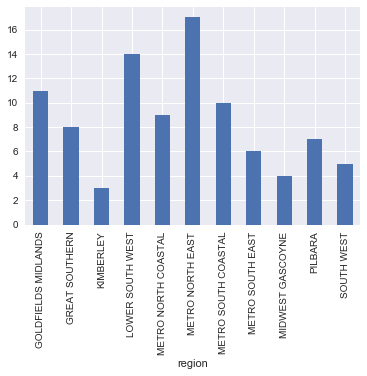

In [24]:
%matplotlib inline 
fire_df.groupby("region").incidentEventsId.count().plot(kind="bar")

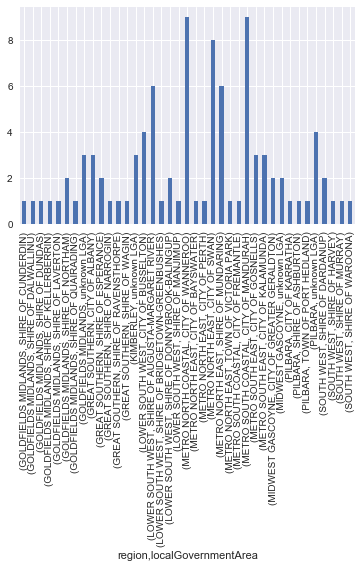

In [25]:
%matplotlib inline 
fire_df.groupby(["region","localGovernmentArea"]).incidentEventsId.count().plot(kind="bar")

#### Fires over time  

- Type of fire / day of the month 

 ![](./images/description_by_data.jpg)
 
 
 
 
 

#### Summary

- The data stored during this exersice allows to identify and segment various fire incidents
- We are able to explore:
    * the areas which received the most fire incidents (potentially most at risk?) 
    * the days of the month when the most incidents happened
    * which incidents are more likely to happen in which areas
    * with continuous updates, based on incident and reporting time, we can explore how fire incidents develop (get resolved, worsen etc)
    


#### Other considerations / further analysis

- Correlating weather conditions with alerts and warnings to day 
- Clustering on long, lat 
- Cross correlating long, lat with business addresses - http://www.corra.com.au/australian-postcode-location-data/
- Cross correlating long,lat with the building in Australia - https://www.geoscape.com.au/product/ 
